In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

from NeuralNMF import Neural_NMF, Energy_Loss_Func, L21_Norm, Recon_Loss_Func
from NeuralNMF import LsqNonneg
from NeuralNMF import train_unsupervised, train_supervised
#
import torch.nn as nn
from NeuralNMF import Writer

from time import time

import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jamiehaddock/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading and Preprocessing 20 Newsgroup Dataset

In [2]:
remove = ('headers','footers','quotes')
stopwords_list = stopwords.words('english')
stopwords_list.extend(['thanks','edu','also','would','one','could','please','really','many','anyone','good','right','get','even','want','must','something','well','much','still','said','stay','away','first','looking','things','try','take','look','make','may','include','thing','like','two','or','etc','phone','oh','email'])

categories = [
 'comp.graphics',
 'comp.sys.mac.hardware',
 'misc.forsale',
 'rec.motorcycles',
 'rec.sport.baseball',
 'sci.med',
 'sci.space',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.religion.misc'
 ]


directory = "categories_5" #this is 100 per class

newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)

# remove numbers
data_cleaned = [re.sub(r'\d+','', file) for file in newsgroups_train.data]

vectorizer = TfidfVectorizer(stop_words=stopwords_list)
vectors = vectorizer.fit_transform(data_cleaned).transpose()
idx_to_word = np.array(vectorizer.get_feature_names())

X = vectors
d, n = np.shape(X)

Y = np.zeros((n))

labels = {0:0, 1:0, 2:1, 3:2, 4:2, 5:3, 6:3, 7:4, 8:4, 9:5}

for i in range(n-1):
    label = newsgroups_train.target[i]
    Y[i] = label

X = torch.from_numpy(X.todense())
Y = torch.from_numpy(Y).long()

m = X.shape[0]
k1 = 10
k2 = 6


sub = 100 #HOW MANY PER CLASS
count = np.zeros((k1))

X_new = torch.zeros((X.shape[0], sub*k1))
Y_new = torch.zeros((sub*k1))
j = 0
for i in range(Y.shape[0]):
    if(count[Y[i]] >= sub):
        continue
    count[Y[i]] += 1
    X_new[:,j] = X[:,i]
    Y_new[j] = labels[int(Y[i])]
    j += 1

X = X_new.double()
Y = Y_new.long()

ind = np.argsort(Y)
X = X[:,ind]
Y = Y[ind]

split = 0.75
L = torch.zeros((k2, Y.shape[0])).double()
for i in range(len(categories)):
    L[:,i*sub:i*sub+(int(split*sub))] = 1

In [3]:
Y_mat = torch.zeros((6,Y.shape[0]))
r = np.arange(Y.shape[0])
Y_mat[[Y,r]] = 1
Y_mat = Y_mat.double()

In [4]:
lambd=1e-6
optimizer="gd"
lr = 1e10

epoch = 100
class_iters=1
weight_decay=0.995

loss_func = Energy_Loss_Func(lambd=lambd) 

all_results = []

for _ in range(10):
    
    start = time()
    
    net = Neural_NMF([m, k1, k2])

    history_supervised = train_unsupervised(net, X, loss_func=loss_func, epoch = epoch, lr = lr, weight_decay=weight_decay, decay_epoch=5, optimizer=optimizer, full_history=True, verbose=True)
    
    end = time()

    print("Training time: {}".format(end-start))
    
    A1_lst = history_supervised.get('A1')
    S1_lst = history_supervised.get('S1')
    S2_lst = history_supervised.get('S2')

    A2 = history_supervised.get('A2')[-1]

    A1 = A1_lst[-1]
    S1 = S1_lst[-1]
    S2 = S2_lst[-1]


    results = {}
    results['X'] = X.detach().numpy()
    results['Y'] = Y.detach().numpy()
    results['A1'] = A1.detach().numpy()
    results['S1'] = S1.detach().numpy()
    results['A2'] = A2.detach().numpy()
    results['S2'] = S2.detach().numpy()
    results['words'] = idx_to_word
    results['loss'] = np.asarray([float(x) for x in history_supervised.get('loss')])
    
    all_results.append(results)
    
np.save("unsupervsed_results_all", all_results)

  0%|          | 0/100 [00:00<?, ?it/s]

Training time: 3046.146931886673


  0%|          | 0/100 [00:00<?, ?it/s]

Training time: 2338.2010691165924


  0%|          | 0/100 [00:00<?, ?it/s]

Training time: 6108.449730157852


  0%|          | 0/100 [00:00<?, ?it/s]

Training time: 27486.11709523201


  0%|          | 0/100 [00:00<?, ?it/s]

Training time: 1879.953901052475


  0%|          | 0/100 [00:00<?, ?it/s]

Training time: 2000.0819489955902


  0%|          | 0/100 [00:00<?, ?it/s]

Training time: 2086.443351984024


  0%|          | 0/100 [00:00<?, ?it/s]

Training time: 2264.970610141754


  0%|          | 0/100 [00:00<?, ?it/s]

Training time: 1852.7074129581451


100%|██████████| 100/100 [58:58<00:00, 35.38s/it] 


Training time: 3538.4819238185883


In [5]:
acc_unknown_all_1 = 0
acc_unknown_all_2 = 0

for res in all_results:
    A1 = res['A1']
    A2 = res['A2']
    S1 = res['S1']
    S2 = res['S2']
    
    B = np.multiply(Y_mat.numpy(),L.numpy()) @ np.linalg.pinv(S1)
    Y_pred = np.argmax(B @ S1, axis=0)
    acc_unknown_1 = Y.numpy()[L[0]==0][Y_pred[L[0]==0]==Y.numpy()[L[0]==0]].shape[0]/ Y[L[0]==0].shape[0]
    
    acc_unknown_all_1 += acc_unknown_1
    
    B = np.multiply(Y_mat.numpy(),L.numpy()) @ np.linalg.pinv(S2)
    Y_pred = np.argmax(B @ S2, axis=0)
    acc_unknown_2 = Y.numpy()[L[0]==0][Y_pred[L[0]==0]==Y.numpy()[L[0]==0]].shape[0]/ Y[L[0]==0].shape[0]
    
    acc_unknown_all_2 += acc_unknown_2

In [6]:
print("Average layer 1 accuracy...   ", acc_unknown_all_1/10)
print("Average layer 2 accuracy...   ", acc_unknown_all_2/10)

Average layer 1 accuracy...    0.5976000000000001
Average layer 2 accuracy...    0.5536


In [7]:
S2 = S2_lst[-1]
S1 = S1_lst[-1]
A2 = history_supervised.get('A2')[-1]

A1 = A1_lst[-1]

In [8]:
B = np.multiply(Y_mat.numpy(),L.numpy()) @ torch.pinverse(S2).numpy()

Y_pred = np.argmax(B @ S2.detach().numpy(), axis=0)


print("Accuracy:          {}/{}".format(Y.numpy()[Y_pred==Y.numpy()].shape[0], Y.shape[0]))
print("Accuracy known:    {}/{}".format(Y.numpy()[L[0]==1][Y_pred[L[0]==1]==Y.numpy()[L[0]==1]].shape[0], Y[L[0]==1].shape[0]))
print("Accuracy unknown:  {}/{}".format(Y.numpy()[L[0]==0][Y_pred[L[0]==0]==Y.numpy()[L[0]==0]].shape[0], Y[L[0]==0].shape[0]))

Accuracy:          554/1000
Accuracy known:    430/750
Accuracy unknown:  124/250


In [9]:
B = np.multiply(Y_mat.numpy(),L.numpy()) @ torch.pinverse(S1).numpy()

Y_pred = np.argmax(B @ S1.detach().numpy(), axis=0)


print("Accuracy:          {}/{}".format(Y.numpy()[Y_pred==Y.numpy()].shape[0], Y.shape[0]))
print("Accuracy known:    {}/{}".format(Y.numpy()[L[0]==1][Y_pred[L[0]==1]==Y.numpy()[L[0]==1]].shape[0], Y[L[0]==1].shape[0]))
print("Accuracy unknown:  {}/{}".format(Y.numpy()[L[0]==0][Y_pred[L[0]==0]==Y.numpy()[L[0]==0]].shape[0], Y[L[0]==0].shape[0]))

Accuracy:          589/1000
Accuracy known:    450/750
Accuracy unknown:  139/250


In [10]:
B1 = Y_mat.numpy() @ torch.pinverse(S1).numpy()
Y_pred = np.argmax(B1 @ S1.detach().numpy(), axis=0)
print("Accuracy: {}/{}".format(Y.numpy()[Y_pred==Y.numpy()].shape[0], Y.shape[0]))

Accuracy: 598/1000


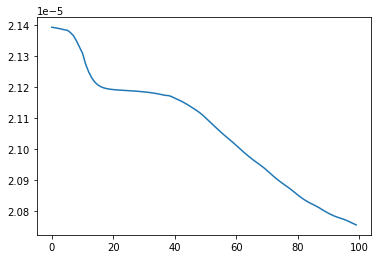

In [11]:
history_supervised.plot_scalar('loss')

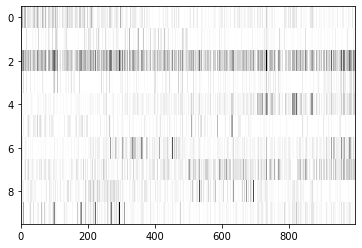

In [12]:
history_supervised.plot_tensor('S1', [-1])

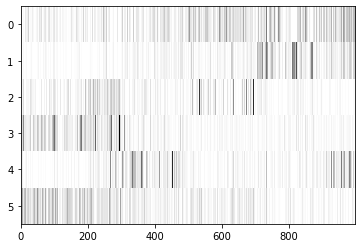

In [13]:
history_supervised.plot_tensor('S2',[-1])

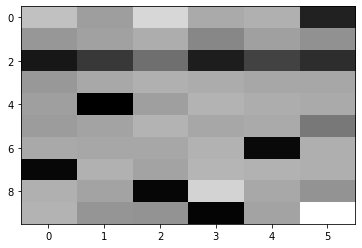

In [14]:
history_supervised.plot_tensor('A2', [-1])

In [15]:
#calculate reconstruction error
layer1_error = torch.norm(X - torch.mm(A1, S1))
layer2_error = torch.norm(X - torch.mm(torch.mm(A1, A2), S2))

print("Layer 1 error...    " + str(layer1_error))
print("Layer 2 error...    " + str(layer2_error))

Layer 1 error...    tensor(30.7174, dtype=torch.float64)
Layer 2 error...    tensor(30.8183, dtype=torch.float64)


In [16]:
keywords = np.empty((12,10), dtype=object)

for i in range(keywords.shape[1]):
    keywords[0,i] = "Topic " + str(i+1)
    keywords[1,i] = "-------"

for i in range(A1.shape[1]):
    col = (A1[:,i]*7/6 -  torch.mean(A1, axis=1)).numpy()
    top = col.argsort()
    top = top[-10:][::-1]

    keywords[2:,i] = idx_to_word[top] 

print("RANK 10 KEYWORDS:")  
print("------------------")
col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for row in keywords:
    print("".join(row[i].ljust(col_widths[i]) for i in range(0,5)))
print("")
for row in keywords:
    print("".join(row[i].ljust(col_widths[i]) for i in range(5,10)))


keywords = np.empty((12,6), dtype=object)

for i in range(keywords.shape[1]):
    keywords[0,i] = "Topic " + str(i+1)
    keywords[1,i] = "-------"

A = torch.mm(A1,A2)
for i in range(A.shape[1]):
    col = (A[:,i]*7/6 -  torch.mean(A, axis=1)).numpy()
    top = col.argsort()
    top = top[-10:][::-1]

    keywords[2:,i] = idx_to_word[top] 

print("RANK 6 KEYWORDS:")  
print("------------------")
col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for row in keywords:
    print("".join(row[i].ljust(col_widths[i]) for i in range(len(row))))


RANK 10 KEYWORDS:
------------------
Topic 1    Topic 2     Topic 3   Topic 4      Topic 5     
-------    -------     -------   -------      -------     
keyboard   bike        know      paranoid     israel      
dos        video       drive     tell         people      
mhz        battery     people    mhz          arab        
modem      motorcycle  think     bit          israeli     
mac        new         system    folks        jews        
apple      display     card      powerpc      armenians   
tiff       riding      problem   nothing      soldiers    
algorithm  card        new       think        turkish     
program    dod         software  acne         government  
use        monitor     mail      engineering  armenian    

Topic 6     Topic 7   Topic 8  Topic 9  Topic 10  
-------     -------   -------  -------  -------   
know        games     gun      space    drive     
banks       game      msg      lunar    mb        
geb         team      diet     nasa     floppy    